In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image

%matplotlib inline

### Vanilla GANs

In [2]:
def leaky_relu(x, alpha=0.01):
    return tf.maximum(x, alpha * x)

def sample_noise(batch_size, dim):
    return tf.random_uniform([batch_size, dim], minval=-1, maxval=1)

def preprocess_img(x):
    return 2 * x - 1.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def show_images(images):
    plt.imshow(images.reshape(176, 176, 3))

(148, 147, 3)
(1, 65268)


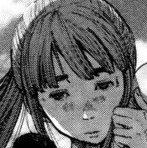

In [3]:
p1 = Image(filename = "pupu.jpeg", width=275, height=275)
p = img.imread("pupu.jpeg")
print(p.shape)
p = p.astype(np.float32)/255
p = p.reshape(1,-1)
print(p.shape)
p1

In [4]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        W1 = tf.get_variable('W1', shape = [92928, 256])
        b1 = tf.get_variable('b1', shape = 256)
        W2 = tf.get_variable('W2', shape = [256,256])
        b2 = tf.get_variable('b2', shape = 256)
        W3 = tf.get_variable('W3', shape = [256,1])
        b3 = tf.get_variable('b3', shape = 1)
        
        a1 = leaky_relu(tf.matmul(x,W1) + b1)
        a2 = leaky_relu(tf.matmul(a1,W2) + b2)
        logits = tf.matmul(a2, W3) + b3
        
        return logits

In [5]:
def generator(z):
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        W1 = tf.get_variable("W1", shape = [z.get_shape()[1], 1024])
        b1 = tf.get_variable("b1", shape = 1024)
        W2 = tf.get_variable("W2", shape = [1024,1024])
        b2 = tf.get_variable("b2", shape = 1024)
        W3 = tf.get_variable("W3", shape = [1024,92928])
        b3 = tf.get_variable("b3", shape= 92928)
        
        a1 = tf.nn.relu(tf.matmul(z,W1) + b1)
        a2 = tf.nn.relu(tf.matmul(a1,W2) + b2)
        img = tf.nn.tanh(tf.matmul(a2, W3) + b3)
        
        return img

In [6]:
def gan_loss(logits_real, logits_fake):
    # TODO: compute D_loss and G_loss
    labels_real = tf.ones_like(logits_real)
    labels_fake = tf.zeros_like(logits_fake)
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_real, logits=logits_real))
    D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_fake, logits=logits_fake))
    
    labels_fake = tf.ones_like(logits_fake)
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_fake, logits=logits_fake))
    
    return D_loss, G_loss

In [22]:
def get_solvers(learning_rate1=1e-7, beta1=0.5, learning_rate2=1e-7, beta2=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate1, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate2, beta1=beta2)
    
    return D_solver, G_solver

In [8]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 1
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 92928])
# random noise fed into our generator
z = sample_noise(1, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [9]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              show_every=100, print_every=100, batch_size=1, num_epoch=500):

    # compute the number of iterations we need
    for epoch in range(num_epoch):
        # every show often, show a sample result
        if epoch % show_every == 0:
            sample = sess.run(G_sample)
            fig = show_images(sample)
            plt.show()
            print()

            # run a batch of data through the network
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: pi})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, D: {:.4}, G:{:.4}'.format(epoch,D_loss_curr,G_loss_curr))
    print('Final images')
    sample = sess.run(G_sample)

    fig = show_images(sample)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


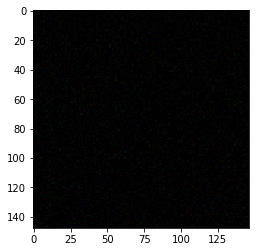


Epoch: 0, D: 1.987, G:2.417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


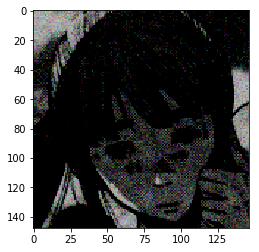


Epoch: 100, D: 2.277, G:6.46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


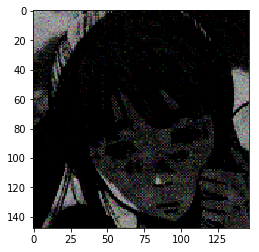


Epoch: 200, D: 0.8029, G:0.9534


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


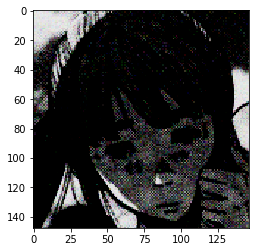


Epoch: 300, D: 0.9501, G:0.7209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


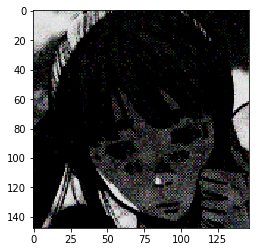


Epoch: 400, D: 1.244, G:0.649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


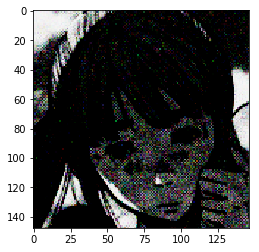


Epoch: 500, D: 1.396, G:0.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


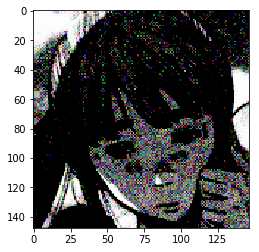


Epoch: 600, D: 2.243, G:0.3692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


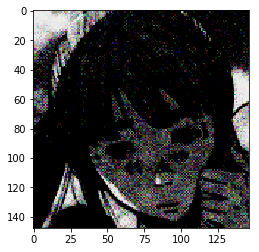


Epoch: 700, D: 0.4535, G:3.814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


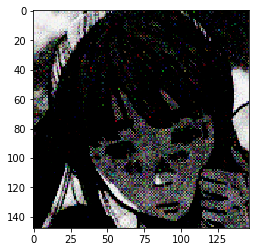


Epoch: 800, D: 0.8526, G:4.277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


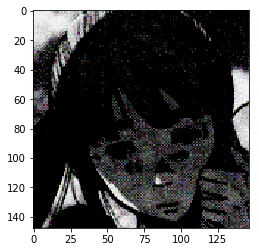


Epoch: 900, D: 0.5459, G:14.22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final images


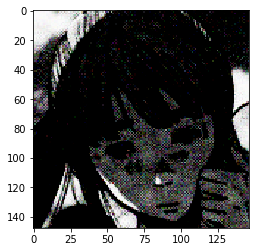

In [19]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

###  Colors

(176, 176, 3)
(1, 92928)


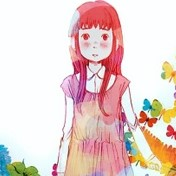

In [10]:
p2 = Image(filename = "colorb.jpg", width=275, height=275)
pi = img.imread("colorb.jpg")
print(pi.shape)
pi = pi.astype(np.float32)
pi = pi.reshape(1,-1)
print(pi.shape)
p2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


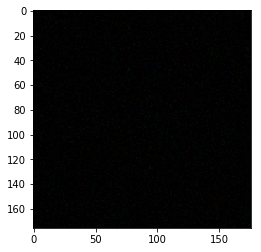


Epoch: 0, D: 0.5986, G:2.528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


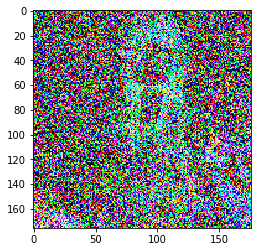


Epoch: 100, D: 2.927e+03, G:0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


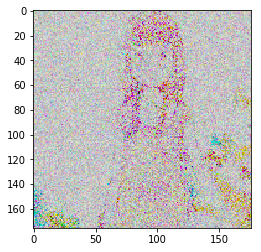


Epoch: 200, D: 3.016e+03, G:0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


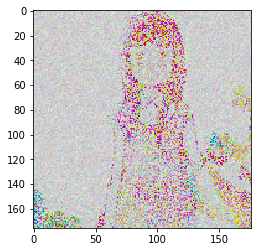


Epoch: 300, D: 3.003e+04, G:0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


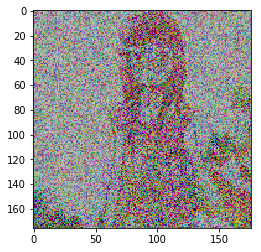


Epoch: 400, D: 3.295e+04, G:0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final images


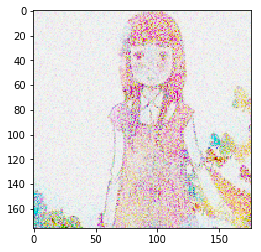

In [30]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

### Least Squares GANs

In [15]:
def lsgan_loss(scores_real, scores_fake):
    # TODO: compute D_loss and G_loss
    G_loss = 0.5 * tf.reduce_mean(tf.square(scores_fake-1))
    D_loss = 0.5 * tf.reduce_mean(tf.square(scores_real-1)) + 0.5 * tf.reduce_mean(tf.square(scores_fake))
    return D_loss, G_loss

In [16]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


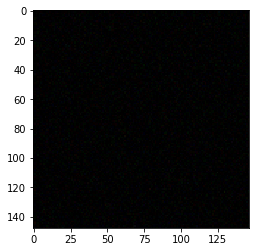


Epoch: 0, D: 0.03579, G:2.815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


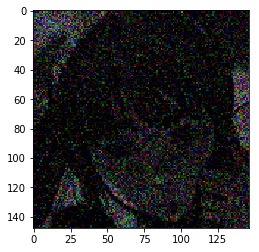


Epoch: 100, D: 0.638, G:2.144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


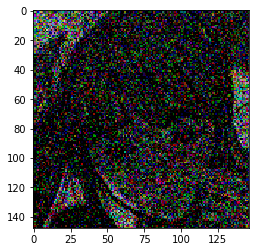


Epoch: 200, D: 6.201, G:79.12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


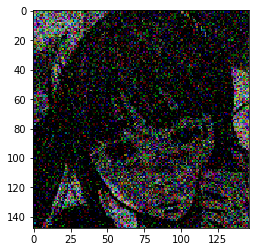


Epoch: 300, D: 0.6966, G:1.683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


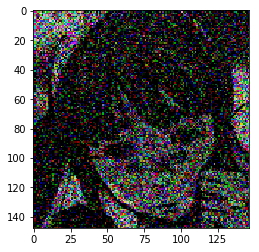


Epoch: 400, D: 1.434, G:0.002654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


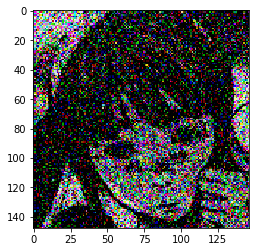


Epoch: 500, D: 22.08, G:9.384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


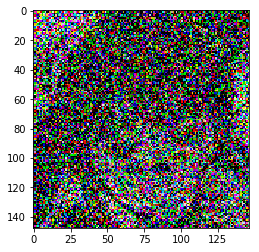


Epoch: 600, D: 1.877, G:0.3636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


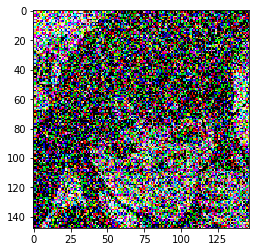


Epoch: 700, D: 0.3588, G:0.009974


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


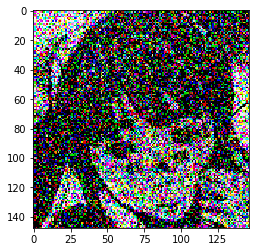


Epoch: 800, D: 3.611, G:0.7548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


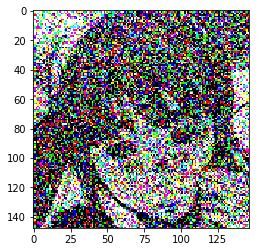


Epoch: 900, D: 0.02217, G:3.139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final images


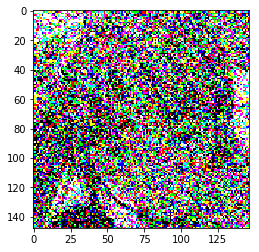

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

### Colors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


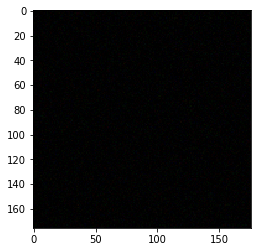


Epoch: 0, D: 4.46e+05, G:1.754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


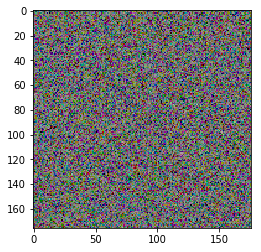


Epoch: 100, D: 1.803, G:0.02798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


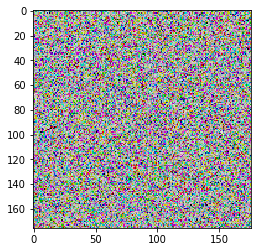


Epoch: 200, D: 0.2282, G:0.4926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


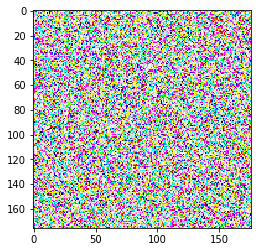


Epoch: 300, D: 1.966e+09, G:1.468e+04


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


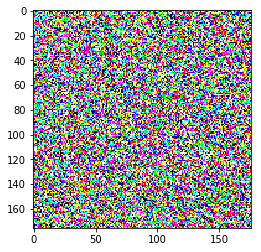


Epoch: 400, D: 0.5116, G:8.335e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final images


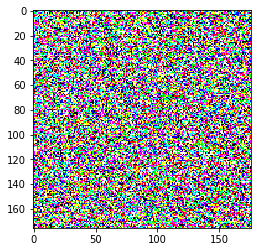

In [23]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

### Deep Convolutional GANs

In [3]:
def show_image(images):
    plt.imshow(images.reshape(168, 168, 3))

(168, 168, 3)
(1, 84672)


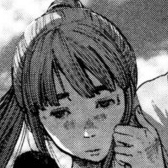

In [6]:
b1 = Image(filename = "bubu1.jpg", width=275, height=275)
b = img.imread("bubu1.jpg")
b = b.astype(np.float32)/255
print(b.shape)
b = b.reshape(1, -1)
print(b.shape)
b1

In [24]:
def get_solver(learning_rate1=0.01, beta1=0.5, learning_rate2=0.002, beta2=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate1, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate2, beta1=beta2)
    
    return D_solver, G_solver

In [8]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, [-1,168,168,3])
        conv1 = tf.layers.conv2d(x, 32, 5, activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv2 = tf.layers.conv2d(pool1, 64, 5, activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
        flatten1 = tf.contrib.layers.flatten(pool2)
        fc1 = tf.contrib.layers.fully_connected(flatten1, 4 * 4 * 64, activation_fn=leaky_relu)
        fc2 = tf.contrib.layers.fully_connected(fc1, 1, activation_fn=None)

        return fc2

In [9]:
def generator(z):
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.contrib.layers.fully_connected(z, 1024)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.contrib.layers.fully_connected(bn1, 7 * 7 * 128)
        bn2 = tf.layers.batch_normalization(fc2)
        img = tf.reshape(bn2, [-1, 7, 7, 128])
        conv1 = tf.layers.conv2d_transpose(img, 64, 4, 2, padding='same', activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(conv1)
        conv2 = tf.layers.conv2d_transpose(bn2, 3, 4, 12, padding='same', activation=tf.tanh)
        img = tf.reshape(conv2, [-1, 84672])
        
        return img

In [23]:
tf.reset_default_graph()

batch_size = 1
# our noise dimension
noise_dim = 300

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 84672])
z = sample_noise(1, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solver()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [22]:
def run_aa_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              show_every=100, print_every=100, batch_size=1, num_epoch=1500):

    # compute the number of iterations we need
    for epoch in range(num_epoch):
        # every show often, show a sample result
        if epoch % show_every == 0:
            sample = sess.run(G_sample)
            fig = show_image(sample)
            plt.show()
            print()

            # run a batch of data through the network
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: b})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, D: {:.4}, G:{:.4}'.format(epoch,D_loss_curr,G_loss_curr))
    print('Final images')
    sample = sess.run(G_sample)

    fig = show_image(sample)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


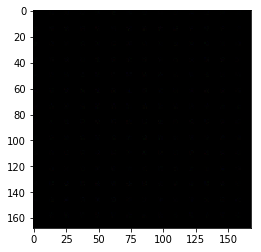


Epoch: 0, D: 1.605, G:0.2808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


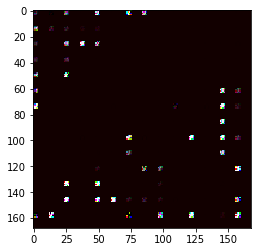


Epoch: 100, D: 1.205e-05, G:11.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


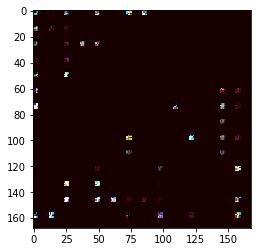


Epoch: 200, D: 1.486e-06, G:13.44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


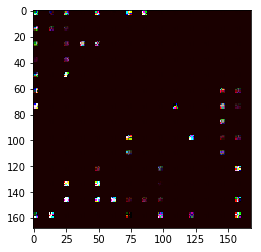


Epoch: 300, D: 5.157e-07, G:14.87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


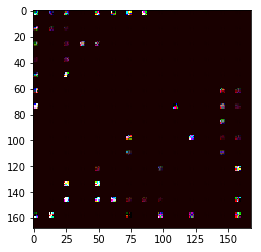


Epoch: 400, D: 3.124e-07, G:15.02


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


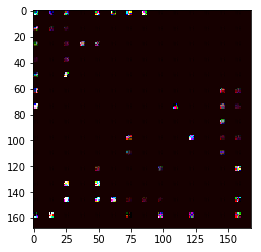


Epoch: 500, D: 2.288e-07, G:15.68


In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_aa_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)